This notebook is based on Aurelien Geron's Chapter 4 of Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow book (2nd edition)

Book link: https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/

Geron's git hub link for this chapter 4: https://github.com/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb


# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# LR using the normal equation

In [2]:
import numpy as np
X = 2 * np.random.rand(100,1)         #rand is from uniform distribution (o to 1)
y = 4 + 3*X + np.random.randn(100,1)  #randn is from normal distribution (mean of 0 and variance of 1)

Saving figure generated_data_plot


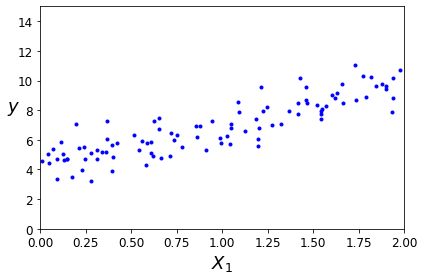

In [3]:
plt.plot(X,y,"b.")
plt.xlabel("$X_1$",fontsize = 18)
plt.ylabel("$y$",rotation = 0, fontsize = 18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [4]:
# compute theta with the Normal Equation
# linalg is matrix inverse in numpy

X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.21509616],
       [2.77011339]])

The function that we used to make y was 4+3x+some_gaussian_noise. So the above is close enough

In [5]:
# now we can make prediction using our theta hat
X_new = np.array([[0],[2]])   #This is setting X=0 and X=2
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict #This is creating the LBF line

array([[4.21509616],
       [9.75532293]])

Saving figure linear_model_predictions_plot


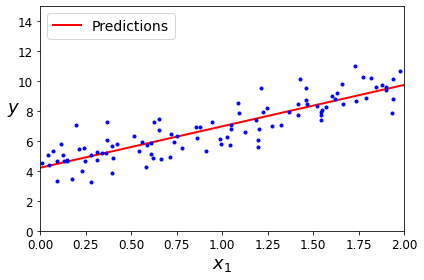

In [6]:
# plot
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

# LR using ScikitLearn

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [8]:
# make a prediction
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

In [9]:
#Lin_reg is based on the scipy.linalg.lstsq() => least squares
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b,y,rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

The above function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the pseudoinverse of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use np.linalg.pinv() to compute the pseudoinverse directly:

In [10]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

# LR using batch gradient descent

In [11]:
eta = 0.1      # learnign rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) #random initialisation

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta)-y)
    theta = theta - eta*gradients

In [12]:
theta

array([[4.21509616],
       [2.77011339]])

## What if using different learning rate

In [13]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

Saving figure gradient_descent_plot


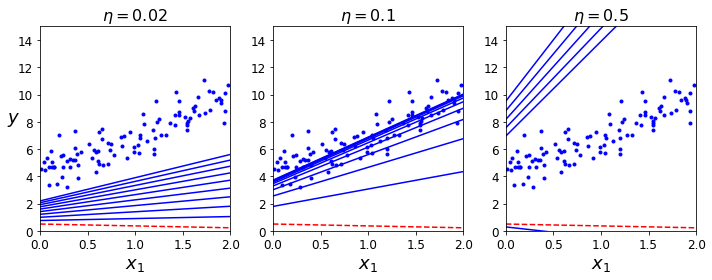

In [14]:
# Plot
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

* Left figure learning rate too low. Convergence takes forever
* Middle figure learning rate about right
* Right figure, learning rate too high. It diverges

# LR using stochastic gradient descetn

In [15]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

Saving figure sgd_plot


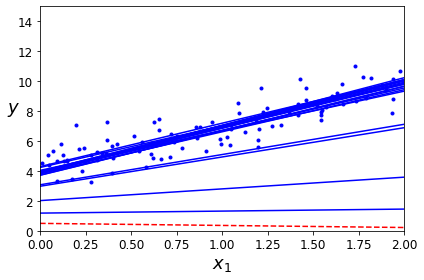

In [16]:
n_epochs = 50   # round of iterations
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
save_fig("sgd_plot")                                 # not shown
plt.show()                                           # not shown

In [17]:
theta

array([[4.21076011],
       [2.74856079]])

In [18]:
from sklearn.linear_model import SGDRegressor

# The code below means start with elarning rate 0.1, runs for maximum 1000 epoch 
# or until the loss in epoch is less than 0.001 during one epoch
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [19]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

# LR using mini-batch gradient descent

In [20]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [21]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [22]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure gradient_descent_paths_plot


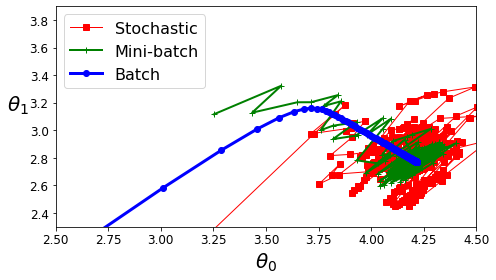

In [23]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

# Polynomial regression

In [24]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [25]:
# generate some data
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

Saving figure quadratic_data_plot


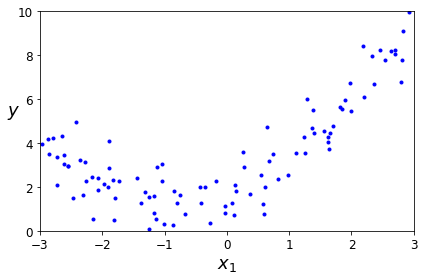

In [26]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

## Via scikit learn

In [27]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias = False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [28]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [29]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Saving figure quadratic_predictions_plot


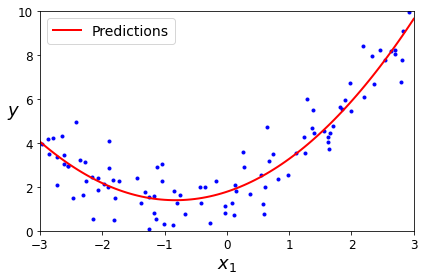

In [30]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

Beware of overfitting. Below is example of a 300 degree polynomial (green line)

## Training curve

In [31]:

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

Saving figure underfitting_learning_curves_plot


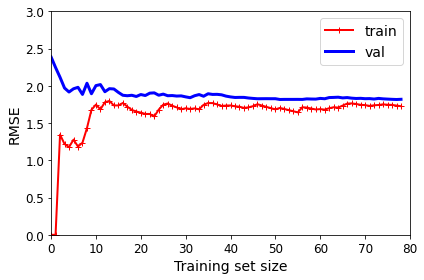

In [32]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
save_fig("underfitting_learning_curves_plot")   # not shown
plt.show()  

Saving figure learning_curves_plot


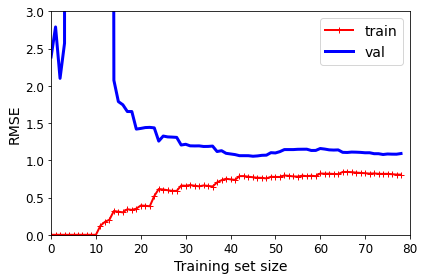

In [33]:

from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
save_fig("learning_curves_plot")  # not shown
#plt.show()     

# Regularised linear model

## Ridge regression

In [34]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

### via Scikit learn

In [35]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [36]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

Saving figure ridge_regression_plot


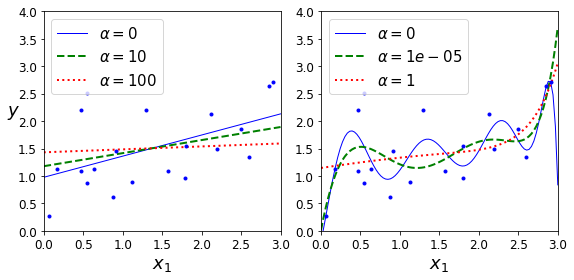

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

plt.figure(figsize=(8,4))
plt.subplot(121)

alpha = 0
style = "b-"
model = Ridge(alpha, solver="cholesky", random_state=42)
model.fit(X,y)
y_new_regul = model.predict(X_new)
lw = 2 if alpha > 0 else 1
plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))

alpha = 10
style = "g--"
model = Ridge(alpha, solver="cholesky", random_state=42)
model.fit(X,y)
y_new_regul = model.predict(X_new)
lw = 2 if alpha > 0 else 1
plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))

alpha = 100
style = "r:"
model = Ridge(alpha, solver="cholesky", random_state=42)
model.fit(X,y)
y_new_regul = model.predict(X_new)
lw = 2 if alpha > 0 else 1
plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left", fontsize=15)
plt.xlabel("$x_1$", fontsize=18)
plt.axis([0, 3, 0, 4])


plt.ylabel("$y$", rotation=0, fontsize=18)


# ------------- POLYNOMIAL

plt.subplot(122)

alpha = 0
style = "b-"
model = Ridge(alpha, solver="cholesky", random_state=42)
model = Pipeline([("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),])
model.fit(X,y)
y_new_regul = model.predict(X_new)
lw = 2 if alpha > 0 else 1
plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))

alpha = 10**-5
style = "g--"
model = Ridge(alpha, solver="cholesky", random_state=42)
model = Pipeline([("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),])
model.fit(X,y)
y_new_regul = model.predict(X_new)
lw = 2 if alpha > 0 else 1
plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))

alpha = 1
style = "r:"
model = Ridge(alpha, solver="cholesky", random_state=42)
model = Pipeline([("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),])
model.fit(X,y)
y_new_regul = model.predict(X_new)
lw = 2 if alpha > 0 else 1
plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left", fontsize=15)
plt.xlabel("$x_1$", fontsize=18)
plt.axis([0, 3, 0, 4])

save_fig("ridge_regression_plot")
plt.show()


### Via gradient descent

In [38]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

In here, L2 is the penalty term. 

## LASSO regression

In [39]:
from sklearn.linear_model import Lasso

In [40]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [41]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

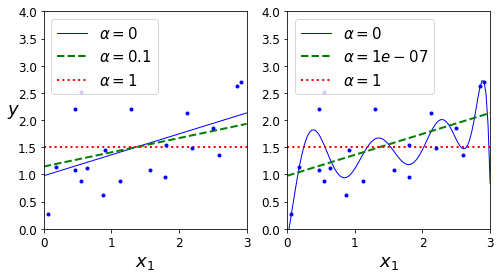

In [46]:
plt.figure(figsize=(8,4))
plt.subplot(121)

alpha = 0
style = "b-"
if alpha == 0:
    model = LinearRegression()
else:
    model = Lasso(alpha , random_state=42)
model.fit(X,y)
y_new_regul = model.predict(X_new)
lw = 2 if alpha > 0 else 1
plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))

alpha = 0.1
style = "g--"
if alpha == 0:
    model = LinearRegression()
else:
    model = Lasso(alpha , random_state=42)
model.fit(X,y)
y_new_regul = model.predict(X_new)
lw = 2 if alpha > 0 else 1
plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))

alpha = 1
style = "r:"
if alpha == 0:
    model = LinearRegression()
else:
    model = Lasso(alpha , random_state=42)
model.fit(X,y)
y_new_regul = model.predict(X_new)
lw = 2 if alpha > 0 else 1
plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left", fontsize=15)
plt.xlabel("$x_1$", fontsize=18)
plt.axis([0, 3, 0, 4])


plt.ylabel("$y$", rotation=0, fontsize=18)


# ------------- POLYNOMIAL

plt.subplot(122)

alpha = 0
style = "b-"
if alpha == 0:
    model = LinearRegression()
else:
    model = Lasso(alpha , random_state=42)
model = Pipeline([("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),])
model.fit(X,y)
y_new_regul = model.predict(X_new)
lw = 2 if alpha > 0 else 1
plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))

alpha = 10**-7
style = "g--"
if alpha == 0:
    model = LinearRegression()
else:
    model = Lasso(alpha , random_state=42)
model.fit(X,y)
y_new_regul = model.predict(X_new)
lw = 2 if alpha > 0 else 1
plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))

alpha = 1
style = "r:"
if alpha == 0:
    model = LinearRegression()
else:
    model = Lasso(alpha , random_state=42)
model.fit(X,y)
y_new_regul = model.predict(X_new)
lw = 2 if alpha > 0 else 1
plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left", fontsize=15)
plt.xlabel("$x_1$", fontsize=18)
plt.axis([0, 3, 0, 4])

#save_fig("lasso_regression_plot")
plt.show()

In [43]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

## ElasticNet

In [48]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

# Early Stopping

In [64]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.10326952])

In [71]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [72]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

Saving figure early_stopping_plot


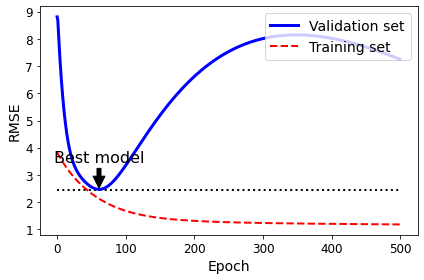

In [73]:
#plot
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

In [74]:
best_epoch, best_model

(61,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))

# Logistic regression

Saving figure logistic_function_plot


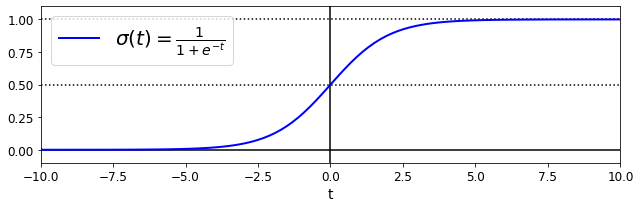

In [75]:

t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

# Iris dataset

In [76]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [77]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

## Only use the width

In [83]:
# Only use the width
X = iris['data'][:,3:]
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0

In [84]:
# training logistic regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

Saving figure logistic_regression_plot


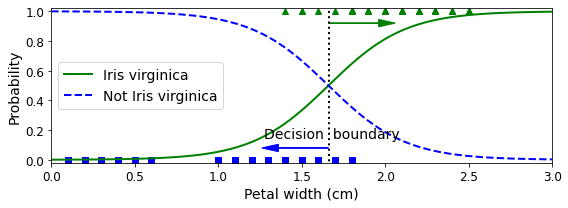

In [89]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

In [95]:

decision_boundary

array([1.66066066])

In [101]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

In [102]:
log_reg.predict_proba([[1.7], [1.5]])

array([[0.45722097, 0.54277903],
       [0.66709636, 0.33290364]])

## Use width and length

Saving figure logistic_regression_contour_plot


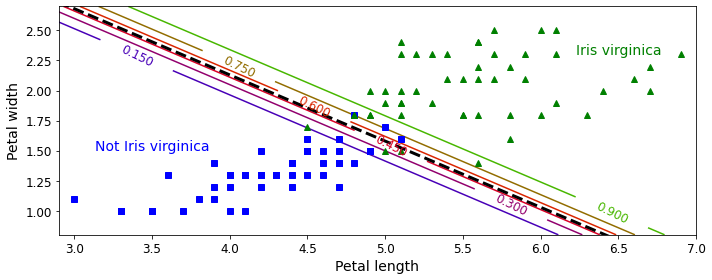

In [108]:

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

## Softmax regression

In [105]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

Saving figure softmax_regression_contour_plot


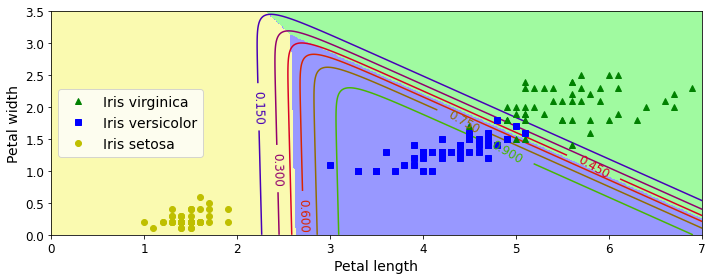

In [106]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

In [109]:
softmax_reg.predict([[5, 2]])

array([2])

In [112]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])